# Naive Bayes Multiclass Classification


In [21]:
import pandas as pd
import numpy as np
import shap

from sklearn.naive_bayes import GaussianNB  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

### Feature Engineering / Data Cleaning

In [22]:
# Import data
from os.path import dirname, join
from pathlib import Path
# ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root 
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
print(data_PATH)
# input data
data_raw = pd.read_csv(data_PATH)

#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other","Elevated"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "Attic" : "Storage",
    "Office" : "Room",
    "TechnicalRoom":"Utility",
    "DraughtLobby" : "Entry",
    "Hall" : "Entry",
    "Basement" : "Storage"
}

data_raw["type_cleaned"] = data_raw["type"].apply(lambda x: merge.get(x,x))
data_raw["exclude"] = ~data_raw["type"].isin(exclusion)

data_cleaned = data_raw[~data_raw["type"].isin(exclusion)]

data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

c:\Spring 2021\Studio Lab II\arch7211-spring2021\data\room_info.csv


,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [23]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = ['type_cleaned']
tier_spc = []
tier_con = ['type_cleaned']
for col in data_cleaned.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)
col_select = {
    'tierA' : tier_fur,
    'tierB' : tier_con,
    'tierC' : tier_spc
            } 
#Creating sub-datasets for each tier : tier1) furniture characteristics tier2) fur + connectivity tier 3) whole dataset
data_tier1a = pd.DataFrame(data_cleaned[col_select['tierA']])
data_tier1b = pd.DataFrame(data_cleaned[col_select['tierB']])
data_tier1c = pd.DataFrame(data_cleaned[col_select['tierC']])
data_tier2 = data_tier1c.copy()
data_tier2[col_select['tierB']] = data_tier1b
# quick view of the dataset grouped by type
# data_tier2.groupby('type_cleaned').count().sort_values('path', ascending= False)


### Functions

In [24]:
# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
# colUniq(data_tier2)

# Normalizing Confusion Matrix
def matNorm (rawMat):
    test_m = rawMat.copy()
    row_sums = test_m.sum(axis=1)
    new_matrix = test_m / row_sums[:, np.newaxis]
    return new_matrix

### Defining Paths

In [25]:
res_PATH = join(ROOT_DIR[:-16],"CSV")
img_PATH = join(ROOT_DIR[:-16],"Charts_Graphs")
print(res_PATH)
print(img_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\CSV
c:\Spring 2021\Studio Lab II\arch7211-spring2021\Charts_Graphs


## Tier 1

In [26]:
#TIER 1) ------------------Group C-----------------------

#Defining Train and Target data
X = data_tier1c.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier1c.columns], axis =1)
y = data_tier1c['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, stratify=y)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2, stratify=y_train)

### Train

In [27]:
gnb_1 = GaussianNB()
gnb_1.fit(X_train_train,y_train_train)
print(gnb_1.get_params())
train_score = gnb_1.score(X_train_train,y_train_train) #Mean accuracy of the data and its labels
print("Tier 1C Training score: ",train_score)

{'priors': None, 'var_smoothing': 1e-09}
Tier 1C Training score:  0.45417988637202095


### Predict

In [28]:
pred_1 = gnb_1.predict(X_test)
# evaluate predictions
accuracy1 = accuracy_score(y_true =y_test, y_pred= pred_1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.29%


In [29]:
# Report Classification Results
file_name = "GNB_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,pred_1,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,pred_1))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.40      0.78      0.53      2187
     Bedroom       0.43      0.91      0.58      2398
     CarPort       0.08      0.01      0.02        84
      Closet       0.22      0.45      0.29       912
      Dining       0.00      0.00      0.00       286
       Entry       0.86      0.27      0.41      1815
      Garage       0.10      0.05      0.06       124
     Kitchen       0.79      0.36      0.49      1364
  LivingRoom       0.52      0.62      0.57      1328
   

In [30]:
file_name = "GNB_Tier1C_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,pred_1)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(pred_1).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Gaussian Naive Bayes Tier1C : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=150)
plt.show()

ValueError: Shape of passed values is (13, 13), indices imply (13, 12)

In [31]:
# # Feature importance
# shap_values = shap.Explainer(pred_1).shap_values(X_train_train)
# shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=gnb_1.classes_, title='Gaussian Naive Bayes Feature Importance', color = plt.get_cmap("tab20b"))
# plt.show()

## Tier 2

In [32]:
#TIER 2) ------------------Group B+C-----------------------

#Defining Train and Target data
X_2 = data_tier2.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier2.columns], axis =1)
y_2 = data_tier2['type_cleaned']
#Split the data into training data, and test data 
X_train2 , X_test2, y_train2, y_test2 = train_test_split(X_2,y_2, test_size= 0.3, stratify=y_2)
X_train_train2 , X_train_val2, y_train_train2, y_train_val2 = train_test_split(X_train2,y_train2, test_size= 0.2, stratify=y_train2)

In [33]:
# Instanciate randomforest classifier 
gnb_2 = GaussianNB()
print(gnb_2.get_params())
# train model 
gnb_2.fit(X_train_train2,y_train_train2)
# Mean accuracy of the data and its labels
train_score = gnb_2.score(X_train_train2,y_train_train2) 
print("Tier 2 Training score: ",train_score)
# predict
pred_2 = gnb_2.predict(X_test2)

{'priors': None, 'var_smoothing': 1e-09}
Tier 2 Training score:  0.4656902530804988


In [34]:
# Evaluate model
# evaluate predictions
accuracy2 = accuracy_score(y_true =y_test2, y_pred= pred_2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print( confusion_matrix(y_test,rfc_pred))
file_name = "GNB_Tier2_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test2,pred_2,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print( classification_report(y_test2,pred_2))

Accuracy: 50.29%
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.39      0.90      0.55      2187
     Bedroom       0.44      0.93      0.59      2398
     CarPort       0.09      0.11      0.10        84
      Closet       0.22      0.26      0.24       912
      Dining       0.00      0.00      0.00       286
       Entry       0.89      0.27      0.41      1

In [35]:
file_name = "GNB_Tier2_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test2,pred_2)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test2).unique() , columns= pd.Series(pred_2).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Gaussian Naive Bayes Tier2 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=150)
plt.show()

ValueError: Shape of passed values is (13, 13), indices imply (13, 10)

## Tier 3

In [36]:
#TIER 3) ------------------Group B+C-----------------------

#Defining Train and Target data
X_3 = data_cleaned.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_cleaned.columns], axis =1)
y_3 = data_cleaned['type_cleaned']
#Split the data into training data, and test data 
X_train3 , X_test3, y_train3, y_test3 = train_test_split(X_3,y_3, test_size= 0.3, stratify=y_3)
X_train_train3 , X_train_val3, y_train_train3, y_train_val3 = train_test_split(X_train3,y_train3, test_size= 0.2, stratify=y_train3)

In [37]:
# Instanciate randomforest classifier 
gnb_3 = GaussianNB()
print(gnb_3.get_params())
# train model 
gnb_3.fit(X_train_train3,y_train_train3)
# Mean accuracy of the data and its labels
train_score = gnb_3.score(X_train_train3,y_train_train3) 
print("Tier 3 Training score: ",train_score)
# predict
pred_3 = gnb_3.predict(X_test3)

{'priors': None, 'var_smoothing': 1e-09}
Tier 3 Training score:  0.4840625691728769


In [38]:
# Evaluate model
# evaluate predictions
accuracy3 = accuracy_score(y_true =y_test3, y_pred= pred_3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print( confusion_matrix(y_test,rfc_pred))
file_name = "GNB_Tier3_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test3,pred_3,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print( classification_report(y_test3,pred_3))

Accuracy: 50.29%
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.40      0.92      0.56      2187
     Bedroom       0.45      0.93      0.60      2398
     CarPort       0.18      0.07      0.10        84
      Closet       0.30      0.36      0.33       912
      Dining       0.00      0.00      0.00       286
       Entry       0.90      0.25      0.39      1815
      Garage       0.50      0.01      0.02       124
     Kitchen       0.84      0.46      0.59      1364
  LivingRoom       0.53      0.63      0

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


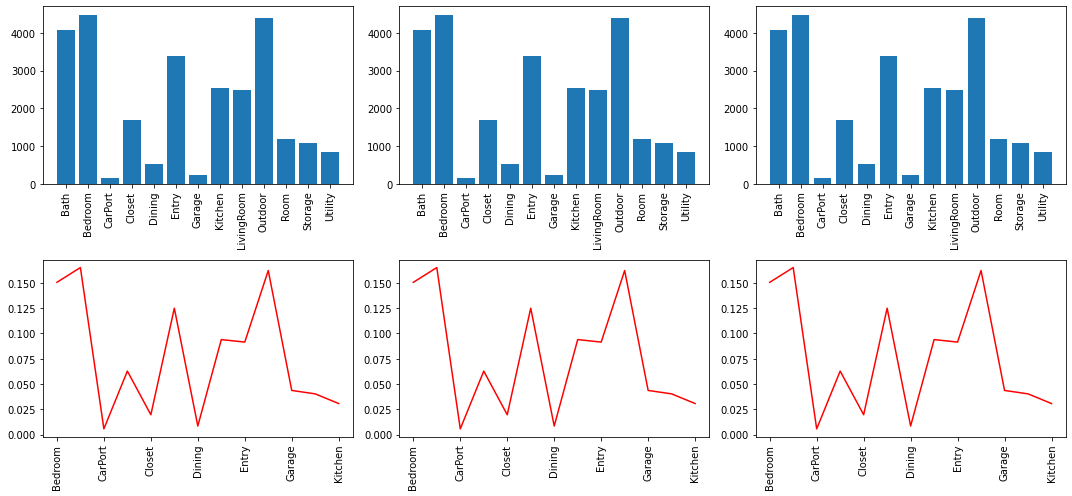

In [39]:
dict1 = (dict(zip(gnb_1.classes_,gnb_1.class_count_)))
dict1_p = (dict(zip(gnb_1.classes_,gnb_1.class_prior_)))
dict2 = (dict(zip(gnb_2.classes_,gnb_2.class_count_)))
dict2_p = (dict(zip(gnb_2.classes_,gnb_2.class_prior_)))
dict3 = (dict(zip(gnb_3.classes_,gnb_3.class_count_)))
dict3_p = (dict(zip(gnb_3.classes_,gnb_3.class_prior_)))

fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7))
axes[0,0].bar(x=np.arange(0,len(dict1.keys())),height = dict1.values(), tick_label = dict1.keys())
axes[1,0].plot(dict1_p.values(), color='r')
axes[0,0].set_xticklabels(labels= dict1.keys(),rotation = 90)
axes[1,0].set_xticklabels(labels= dict1.keys(),rotation = 90)

axes[0,1].bar(x=np.arange(0,len(dict2.keys())),height = dict2.values(), tick_label = dict2.keys())
axes[1,1].plot(dict2_p.values(), color='r')
axes[0,1].set_xticklabels(labels= dict1.keys(),rotation = 90)
axes[1,1].set_xticklabels(labels= dict1.keys(),rotation = 90)

axes[0,2].bar(x=np.arange(0,len(dict3.keys())),height = dict3.values(), tick_label = dict3.keys())
axes[1,2].plot(dict3_p.values(), color='r')
axes[0,2].set_xticklabels(labels= dict1.keys(),rotation = 90)
axes[1,2].set_xticklabels(labels= dict1.keys(),rotation = 90)

plt.tight_layout()


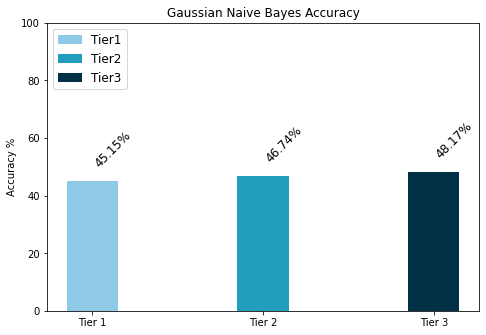

In [145]:
file_name = "GNB_acu.png"
fig_PATH = join(img_PATH,file_name)
fig1 = plt.figure()
ax = fig1.add_axes([0.1,0.1,1,1])
ax.bar(x='Tier 1', height = accuracy1*100,width=0.3, label='Tier1', color='#8ecae6')
ax.bar(x='Tier 2', height = accuracy2*100,width=0.3, label='Tier2', color='#219ebc')
ax.bar(x='Tier 3', height = accuracy3*100,width=0.3, label='Tier3', color='#023047')
# ax.set_xticklabels(labels= ['Tier 1','Tier 2','Tier 3'], fontsize=10,)
ax.set_title('Gaussian Naive Bayes Accuracy')
ax.set_ylim(0,100)
ax.legend(loc=2, fontsize=12)
ax.set_ylabel('Accuracy %')
ax.text('Tier 1', accuracy1*100+5, "%.2f%%" % (accuracy1 * 100.0), color='black', rotation=45, fontsize=12)
ax.text('Tier 2', accuracy2*100+5, "%.2f%%" % (accuracy2 * 100.0), color='black', rotation=45, fontsize=12)
ax.text('Tier 3', accuracy3*100+5, "%.2f%%" % (accuracy3 * 100.0), color='black', rotation=45, fontsize=12)
fig1.savefig(fig_PATH,dpi=300)

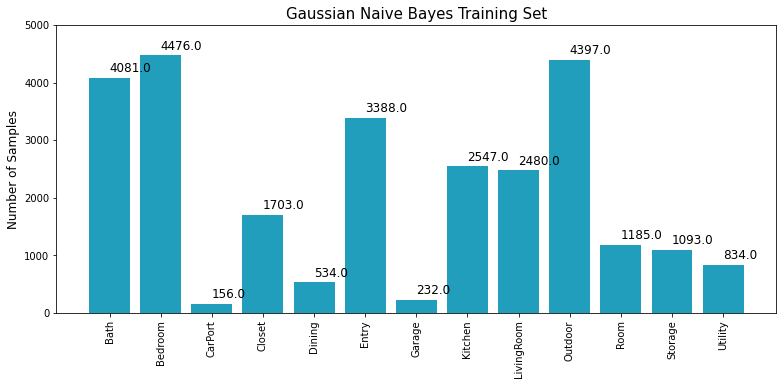

In [194]:
file_name = "GNB_classes.png"
fig_PATH = join(img_PATH,file_name)
fig2 = plt.figure(figsize=(10,8))
ax = fig2.add_axes([0.1,0.1,1,.5])
ax.bar(x=np.arange(0,len(dict1.keys())),height = dict1.values(), tick_label = dict1.keys() ,color="#219ebc")
ax.set_xticklabels(labels= dict1.keys(),rotation = 90)

# ax.set_xticklabels(labels= ['Tier 1','Tier 2','Tier 3'], fontsize=10,)
ax.set_title('Gaussian Naive Bayes Training Set',fontweight='normal', fontsize=15)
# ax.set_ylim(0,100)
ax.set_ylabel('Number of Samples',fontweight='normal', fontsize=12)
ax.set_ylim(0,5000)
for i,val in enumerate(dict1.values()):
    ax.text(x=np.arange(0,len(dict1.keys()))[i],y =val+100,  s= str(val), color='black', fontweight='normal', rotation=0, fontsize=12)


fig2.savefig(fig_PATH,dpi=300)